In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
train = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv", index_col = 'Date',parse_dates = ['Date'])
test = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv", index_col = 'Date',parse_dates = ['Date'])

## Glimpse of the Data

In [2]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title="Pandas Profiling Report")
train.profile_report()

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_20/3977990253.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Performing ADF test to check stationarity:

In [3]:
t = sm.tsa.adfuller(train.Close, autolag=None)
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.720507
p-value                          0.420579
#Lags Used                      16.000000
Number of Observations Used    283.000000
dtype: float64

##### p-value is greater than 0.05. So the data is non-stationary

#### Differencing the closed column to convert it to stationary:

In [4]:
train['differenced_close'] = train['Close'].diff(1)
train['differenced_close'][0] = 0

/tmp/ipykernel_20/2828488668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['differenced_close'][0] = 0


#### Performing ADF test after differencing to check stationarity:

In [5]:
t = sm.tsa.adfuller(train.differenced_close, autolag=None)
pd.Series(t[0:4], index=['Test Statistic','p-value',
                         '#Lags Used','Number of Observations Used'])

Test Statistic                  -4.545992
p-value                          0.000162
#Lags Used                      16.000000
Number of Observations Used    283.000000
dtype: float64

##### Since the p-value is signinficantly lesser than 0.05, the data is now stationary

### Plotting ACF and PACF for autocorrelation analysis:

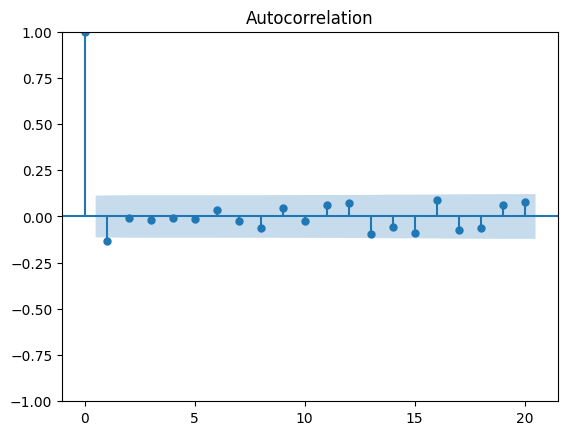

In [6]:
plot_acf(train.differenced_close,lags=20)
plt.show()

#### q = 1

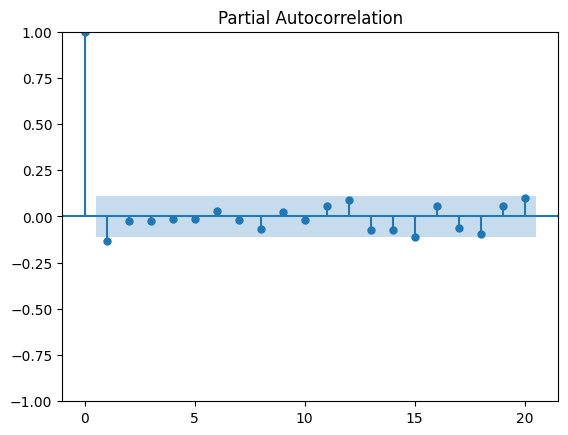

In [7]:
plot_pacf(train.differenced_close,lags=20)
plt.show()

#### p = 1

### Decomposition of Time Series Data

In the code, we are decomposing the `differenced_close` column into its constituent components, which are the trend, seasonal, and residual components. 
The choice of using the additive model for decomposition is based on several reasons:

1. **Steady Seasonal Variations**: The seasonal variations in our time series data remain relatively constant and do not exhibit a strong dependence on the level of the time series. This suggests that a consistent seasonal pattern is present throughout the data.

2. **Constant Seasonal Amplitude**: The additive model assumes that the seasonal component has a constant amplitude or magnitude. In other words, it treats seasonal fluctuations as fixed values that are added to the trend.

3. **Unchanging Seasonal Fluctuations**: The magnitude of seasonal fluctuations does not significantly increase or decrease with changes in the level of the time series. This implies that the seasonal pattern maintains a consistent influence on the data over time.


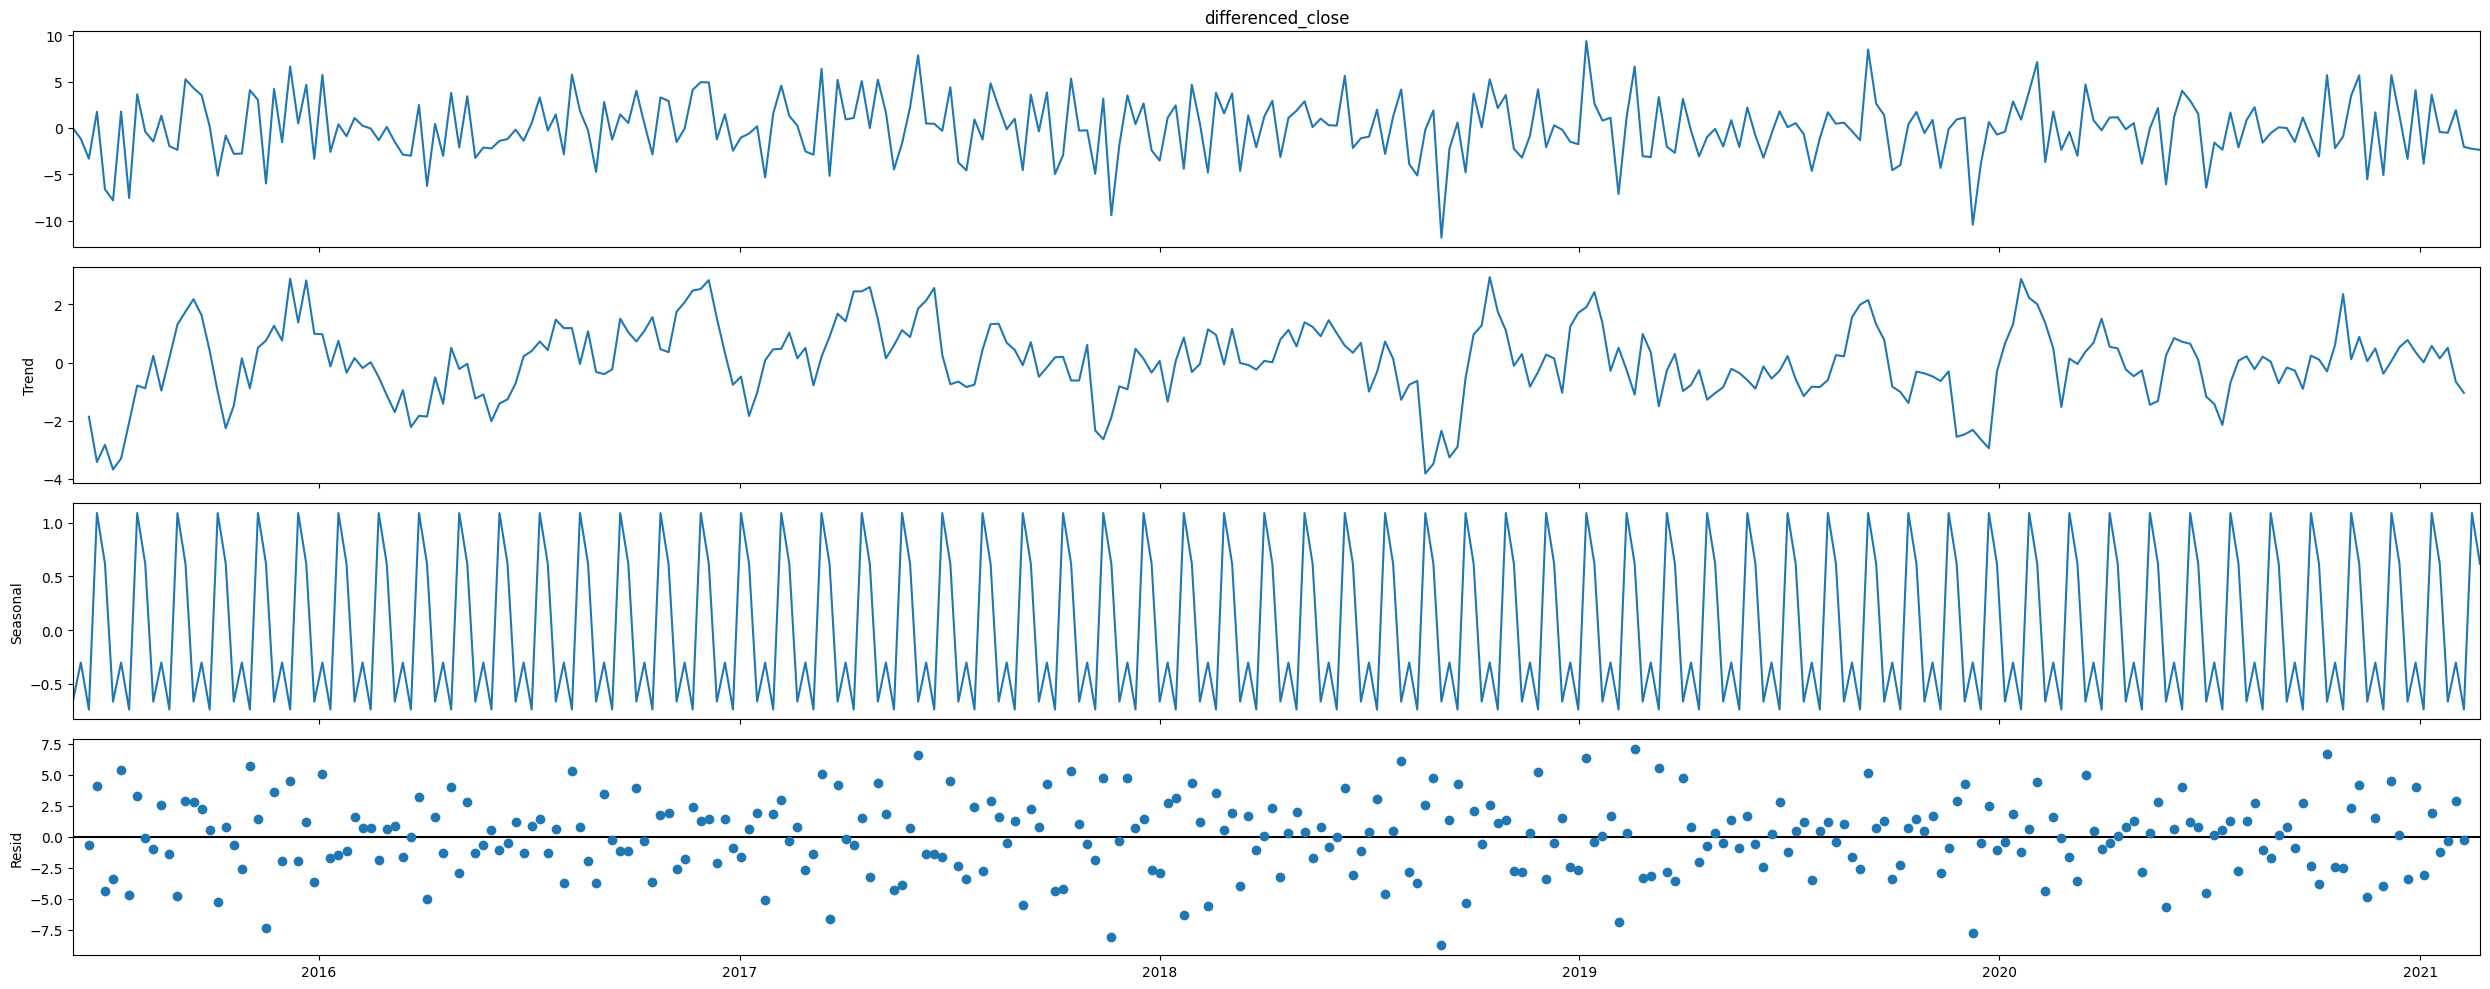

In [8]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 25, 10
decomposition = seasonal_decompose(train.differenced_close, model='additive', period = 5)
fig = decomposition.plot()

plt.show()

### Exploring the seasonal component of the decomposed data

In [9]:
seasonal_component = decomposition.seasonal
seasonal_component.head()

Date
2015-06-01   -0.666204
2015-06-08   -0.302466
2015-06-15   -0.740071
2015-06-22    1.090429
2015-06-29    0.618312
Name: seasonal, dtype: float64

#### Function to check whether a series is stationary or not using ADF test:

In [10]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [11]:
check_stationarity(seasonal_component)

The series is stationary


#### Conclusion : The seasonal component of the time series data is stationary, hence D = 0

### Plotting ACF and PACF for the seasonal component:

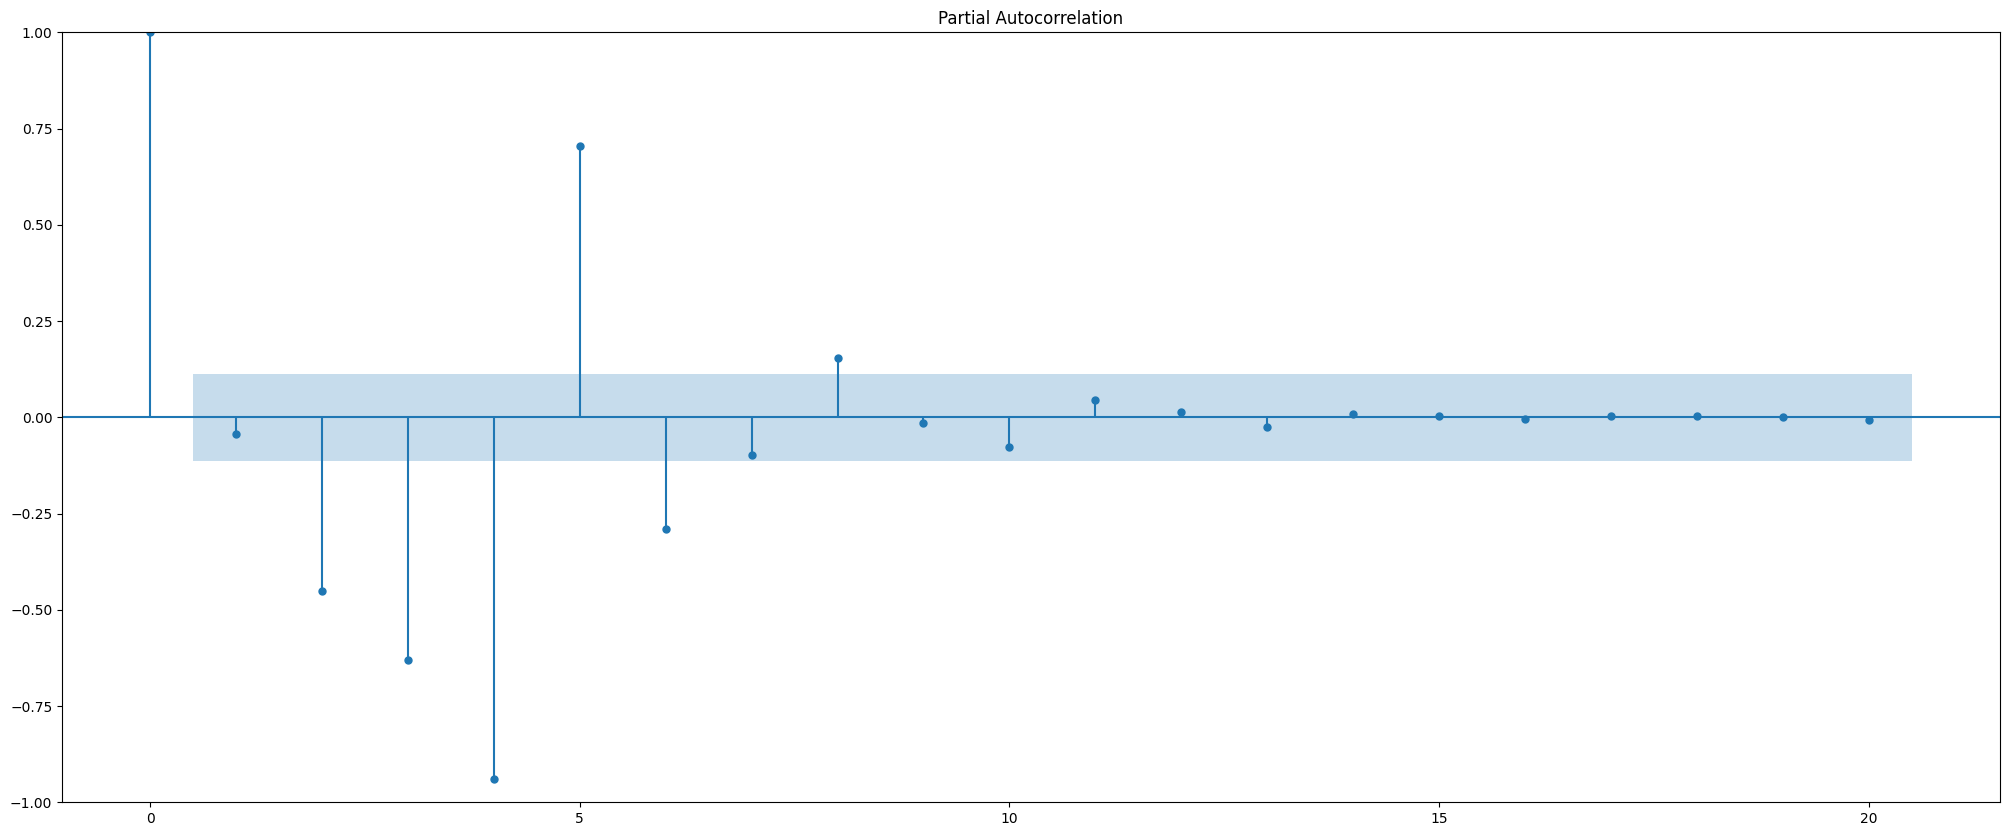

In [12]:
plot_pacf(seasonal_component, lags =20)
plt.show()

### P = 5
#### We have considered the 5 most signinficant lags

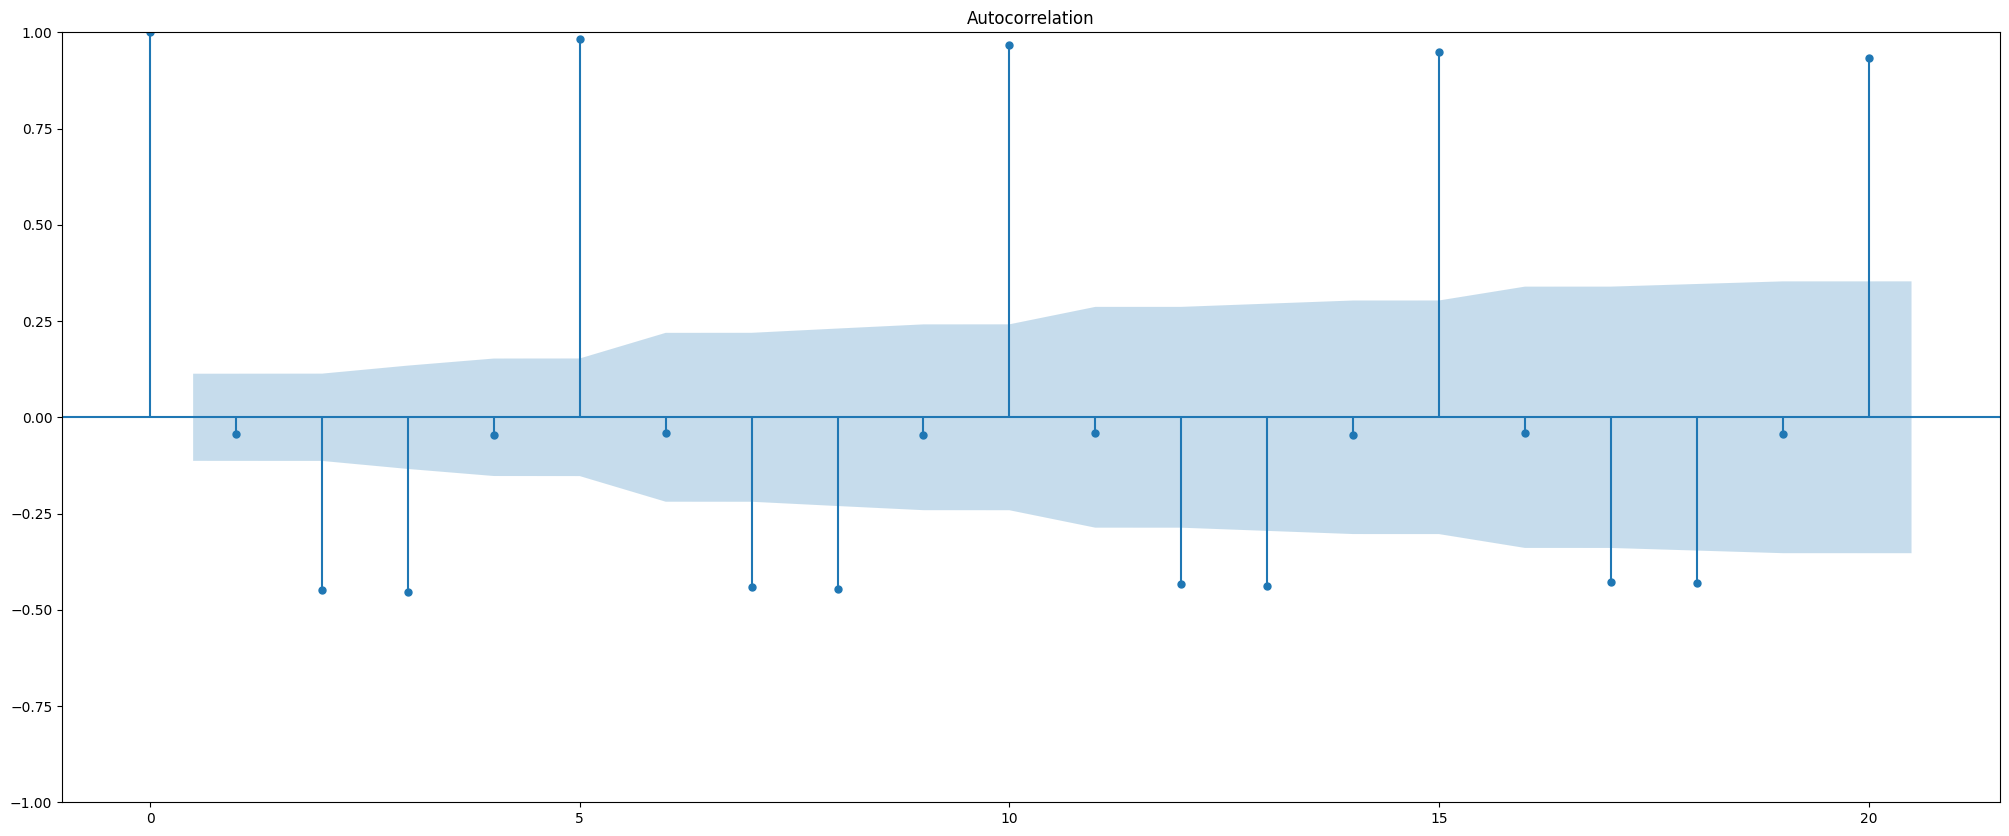

In [13]:
plot_acf(seasonal_component,lags =20)
plt.show()


### Q = 0 as there is a repetitive pattern in the plot

#### Functions to calculate RSI and MACD 

In [14]:
# Function to calculate RSI
def calculate_rsi(data, window):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD
def calculate_macd(data, short_window, long_window):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=9, adjust=False).mean()
    return macd, signal_line

### Feature Engineering Summary

In the provided code, various features have been engineered from the 'train' dataset, primarily focusing on the 'Close' and 'Volume' columns. These features include:

1. **Lagged 'Open' and 'Close' Prices**:
   - 'OpenL', 'OpenL2', 'OpenL3', 'OpenL4': Lagged 'Open' prices with different time lags.
   - 'CloseL', 'CloseL2': Lagged 'Close' prices with different time lags.

2. **Exponential Weighted Moving Averages (EWMA)**:
   - 'EWMA_close' and 'EWMA_close2': Exponential Weighted Moving Averages of 'Close' prices with different spans.
   - 'EWMA_open' and 'EWMA_open2': Exponential Weighted Moving Averages of 'Open' prices with different spans.

3. **Simple Moving Averages (SMA)**:
   - 'SMA_open' and 'SMA_open2': SMA of 'Open' prices with different window sizes.
   - 'SMA_close' and 'SMA_close2': SMA of 'Close' prices with different window sizes.

4. **Relative Strength Index (RSI)**:
   - 'RSI': Calculated Relative Strength Index for 'Close' prices.

5. **Moving Average Convergence Divergence (MACD)**:
   - 'MACD' and 'Signal_Line': MACD and Signal Line calculated based on 'Close' prices.

6. **Volume Features**:
   - 'Weekly_Volume_Change': Weekly change in volume.
   - 'Monthly_Volume_Change': Monthly change in volume spanning 5 weeks.
   - 'Quarterly_Volume_Change': Quarterly change in volume spanning 20 weeks.
   - 'Volume_MA_5', 'Volume_MA_10', 'Volume_MA_20', 'Volume_MA_50': Volume Moving Averages with different window sizes.
   - 'Volume_EMA_5', 'Volume_EMA_10', 'Volume_EMA_20', 'Volume_EMA_50': Volume Exponential Moving Averages with different spans.

The code effectively adds these features to the 'train' DataFrame, enhancing its information for further analysis and modeling.


In [15]:

#Train Feature Engineering
train['differenced_close'] = train['Close'].diff(1)
train['OpenL'] = train['Open'].shift(1)
train['OpenL'][0] = train['Open'][0]
train['differenced_close'][0] = 0 #temporarily ive filled with 0 ok dont mind this,this aint the error

train['OpenL2'] = train['Open'].shift(2)
train['OpenL2'][0:2] = train['Open'][0:2]
train['OpenL3'] = train['Open'].shift(3)
train['OpenL3'][0:3] = train['Open'][0:3]
train['OpenL4'] = train['Open'].shift(4)
train['OpenL4'][0:4] = train['Open'][0:4]




train['CloseL'] = train['Close'].shift(1)
train['CloseL'][0] = train['Close'][0]
train['CloseL2'] = train['Close'].shift(2)
train['CloseL2'][0:2] = train['Close'][0:2]

#Exponential Weighted Moving Average over a window of 5 weeks
train['EWMA_close'] = train['Close'].ewm(span=5, adjust=False).mean()

#Exponential Weighted Moving Average over a window of 10 weeks
train['EWMA_close2'] = train['Close'].ewm(span=10, adjust=False).mean()
#Exponential Weighted Moving Average over a window of 5 weeks for open prices
train['EWMA_open'] = train['Open'].ewm(span=5, adjust=False).mean()
#Exponential Weighted Moving Average over a window of 10 weeks for open prices
train['EWMA_open2'] = train['Open'].ewm(span=10, adjust=False).mean()
#SMA over a window of 5 weeks on Open
train['SMA_open'] = train['Open'].rolling(window=5).mean()
#SMA over a window of 10 weeks on Open
train['SMA_open2'] = train['Open'].rolling(window=10).mean()
#SMA over a window of 5 weeks on Close
train['SMA_close'] = train['Close'].rolling(window=5).mean()
#SMA over a window of 10 weeks on Close
train['SMA_close2'] = train['Close'].rolling(window=10).mean()
train['RSI'] = calculate_rsi(train['Close'], window=14)
train['MACD'], train['Signal_Line'] = calculate_macd(train['Close'], short_window=12, long_window=26)


# Assuming you have a DataFrame 'train' with weekly data

# Create a weekly change in volume feature
train['Weekly_Volume_Change'] = train['Volume'].diff(1)
train['Weekly_Volume_Change'][0] = 0  # Fill the first value with 0

# Create a monthly change in volume feature (spanning 5 weeks)
train['Monthly_Volume_Change'] = train['Volume'].diff(5)
train['Monthly_Volume_Change'][:5] = 0  # Fill the first 5 values with 0

# Create a quarterly change in volume feature (spanning 20 weeks)
train['Quarterly_Volume_Change'] = train['Volume'].diff(20)
train['Quarterly_Volume_Change'][:20] = 0  # Fill the first 20 values with 0



train['Volume_MA_10'] = train['Volume'].rolling(window=10).mean()
train['Volume_MA_20'] = train['Volume'].rolling(window=20).mean()
train['Volume_MA_50'] = train['Volume'].rolling(window=50).mean()
train['Volume_MA_5'] = train['Volume'].rolling(window=5).mean()

train['Volume_MA_10'].fillna(method='ffill', inplace=True)
train['Volume_MA_20'].fillna(method='ffill', inplace=True)
train['Volume_MA_50'].fillna(method='ffill', inplace=True)
train['Volume_MA_5'].fillna(method='ffill', inplace=True)

# Calculate Exponential Moving Averages (EMAs) for volume with different spans
train['Volume_EMA_10'] = train['Volume'].ewm(span=10, adjust=False).mean()
train['Volume_EMA_20'] = train['Volume'].ewm(span=20, adjust=False).mean()
train['Volume_EMA_50'] = train['Volume'].ewm(span=50, adjust=False).mean()
train['Volume_EMA_5'] = train['Volume'].ewm(span=5, adjust=False).mean()

train['Volume_EMA_10'].fillna(method='ffill', inplace=True)
train['Volume_EMA_20'].fillna(method='ffill', inplace=True)
train['Volume_EMA_50'].fillna(method='ffill', inplace=True)
train['Volume_EMA_5'].fillna(method='ffill', inplace=True)




# Handle missing values
train.fillna(method='bfill', inplace=True)

/tmp/ipykernel_20/3197477696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['OpenL'][0] = train['Open'][0]
/tmp/ipykernel_20/3197477696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['differenced_close'][0] = 0 #temporarily ive filled with 0 ok dont mind this,this aint the error
/tmp/ipykernel_20/3197477696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['OpenL2'][0:2] = train['Open'][0:2]
/tmp/ipykernel

### Correlation matrix for numeric columns in the 'train' dataset, providing insights into the relationships between these variables

In [16]:
# Correlation matrix
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr = train[numeric_cols].iloc[0:-1].corr()
corr.style.background_gradient(cmap='coolwarm')



,id,Open,Close,Volume,differenced_close,OpenL,OpenL2,OpenL3,OpenL4,CloseL,CloseL2,EWMA_close,EWMA_close2,EWMA_open,EWMA_open2,SMA_open,SMA_open2,SMA_close,SMA_close2,RSI,MACD,Signal_Line,Weekly_Volume_Change,Monthly_Volume_Change,Quarterly_Volume_Change,Volume_MA_10,Volume_MA_20,Volume_MA_50,Volume_MA_5,Volume_EMA_10,Volume_EMA_20,Volume_EMA_50,Volume_EMA_5
id,1.000000,0.549609,0.563281,-0.471709,-0.003931,0.555307,0.560614,0.569220,0.573257,0.564146,0.564550,0.579034,0.594053,0.572936,0.592099,0.577533,0.602337,0.578613,0.606692,0.060803,-0.023015,-0.029124,0.007575,0.017659,0.168795,-0.698724,-0.761020,-0.878798,-0.628373,-0.704929,-0.773127,-0.874239,-0.636634
Open,0.549609,1.000000,0.927969,-0.461328,0.067946,0.971363,0.949461,0.931048,0.918748,0.911921,0.894997,0.919627,0.901407,0.982241,0.960736,0.972235,0.947102,0.914238,0.897770,0.344677,0.469743,0.476799,-0.006564,-0.003340,0.038359,-0.635328,-0.663380,-0.727582,-0.598329,-0.650631,-0.683146,-0.714724,-0.604375
Close,0.563281,0.927969,1.000000,-0.461080,0.116954,0.950135,0.970406,0.987932,0.970626,0.972439,0.952257,0.982285,0.958747,0.972709,0.974554,0.978550,0.967288,0.972805,0.942540,0.377893,0.521451,0.517538,0.005366,0.004245,0.058314,-0.634479,-0.663559,-0.724209,-0.605031,-0.659226,-0.689891,-0.719333,-0.612137
Volume,-0.471709,-0.461328,-0.461080,1.000000,-0.055093,-0.457438,-0.460098,-0.465321,-0.451887,-0.448098,-0.436687,-0.451216,-0.439198,-0.467195,-0.463669,-0.470620,-0.483162,-0.449331,-0.459664,-0.253435,-0.171730,-0.136627,0.448722,0.546894,0.378454,0.665776,0.625810,0.544582,0.723334,0.755768,0.683085,0.609986,0.847085
differenced_close,-0.003931,0.067946,0.116954,-0.055093,1.000000,0.092677,0.086223,0.086716,-0.066435,-0.117827,-0.086550,-0.024509,-0.051389,0.050328,0.012814,0.054335,-0.002104,-0.050856,-0.052277,0.268017,0.024649,-0.036938,-0.043751,-0.048150,-0.030286,-0.024329,-0.011341,-0.011355,-0.014294,-0.014193,-0.007145,-0.003807,-0.027300
OpenL,0.555307,0.971363,0.950135,-0.457438,0.092677,1.000000,0.971405,0.948063,0.930161,0.928279,0.912646,0.938892,0.919981,0.987615,0.971844,0.982698,0.958154,0.932578,0.912904,0.348058,0.480387,0.486173,0.007662,0.006521,0.051527,-0.635719,-0.665140,-0.728071,-0.600264,-0.653589,-0.686013,-0.717365,-0.606438
OpenL2,0.560614,0.949461,0.970406,-0.460098,0.086223,0.971405,1.000000,0.969442,0.947866,0.950063,0.928588,0.958384,0.938705,0.983630,0.976616,0.986216,0.966150,0.950494,0.928228,0.360166,0.491371,0.495810,0.000731,0.012583,0.061940,-0.636095,-0.666716,-0.728493,-0.600493,-0.656927,-0.689235,-0.720216,-0.609158
OpenL3,0.569220,0.931048,0.987932,-0.465321,0.086716,0.948063,0.969442,1.000000,0.971548,0.967471,0.947292,0.975386,0.954975,0.973431,0.975462,0.982204,0.971885,0.967542,0.943984,0.371586,0.501095,0.504116,-0.002308,-0.000634,0.056940,-0.645213,-0.674568,-0.732356,-0.607209,-0.663503,-0.695938,-0.726242,-0.614809
OpenL4,0.573257,0.918748,0.970626,-0.451887,-0.066435,0.930161,0.947866,0.971548,1.000000,0.986122,0.965810,0.981533,0.965905,0.963148,0.973011,0.971891,0.974751,0.978746,0.957168,0.328242,0.496436,0.510206,0.017643,0.012128,0.061039,-0.648996,-0.679004,-0.733566,-0.608043,-0.663890,-0.698262,-0.729151,-0.611672
CloseL,0.564146,0.911921,0.972439,-0.448098,-0.117827,0.928279,0.950063,0.967471,0.986122,1.000000,0.972477,0.987936,0.970712,0.960792,0.971444,0.965692,0.967682,0.984643,0.954715,0.314931,0.515610,0.526156,0.015637,0.015549,0.065418,-0.628702,-0.660828,-0.721468,-0.601613,-0.655825,-0.688141,-0.718364,-0.605664


In [17]:
train.head(10)

,id,Open,Close,Volume,Strategy,differenced_close,OpenL,OpenL2,OpenL3,OpenL4,...,Monthly_Volume_Change,Quarterly_Volume_Change,Volume_MA_10,Volume_MA_20,Volume_MA_50,Volume_MA_5,Volume_EMA_10,Volume_EMA_20,Volume_EMA_50,Volume_EMA_5
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold,0.000000,66.208486,66.208486,66.208486,66.208486,...,0.0,0.0,360090440.0,343104950.0,275852788.0,281516240.0,2.985063e+08,2.985063e+08,2.985063e+08,2.985063e+08
2015-06-08,1,64.116235,74.443331,227974800,Hold,-1.166647,66.208486,64.116235,64.116235,64.116235,...,0.0,0.0,360090440.0,343104950.0,275852788.0,281516240.0,2.856824e+08,2.917890e+08,2.957404e+08,2.749958e+08
2015-06-15,2,47.701942,71.140831,250670900,Buy,-3.302500,64.116235,66.208486,47.701942,47.701942,...,0.0,0.0,360090440.0,343104950.0,275852788.0,281516240.0,2.793167e+08,2.878730e+08,2.939729e+08,2.668875e+08
2015-06-22,3,54.754816,72.881344,223614300,Hold,1.740512,47.701942,64.116235,66.208486,54.754816,...,0.0,0.0,360090440.0,343104950.0,275852788.0,281516240.0,2.691890e+08,2.817531e+08,2.912138e+08,2.524631e+08
2015-06-29,4,48.031899,66.284718,406814900,Buy,-6.596626,54.754816,47.701942,64.116235,66.208486,...,0.0,0.0,360090440.0,343104950.0,275852788.0,281516240.0,2.942119e+08,2.936638e+08,2.957471e+08,3.039137e+08
2015-07-06,5,51.374399,58.494017,590857400,Buy,-7.790701,48.031899,54.754816,47.701942,64.116235,...,292351100.0,0.0,360090440.0,343104950.0,275852788.0,339986460.0,3.481474e+08,3.219679e+08,3.073201e+08,3.995616e+08
2015-07-13,6,45.851376,60.269347,693570200,Buy,1.775330,51.374399,48.031899,54.754816,47.701942,...,465595400.0,0.0,360090440.0,343104950.0,275852788.0,433105540.0,4.109516e+08,3.573586e+08,3.224672e+08,4.975645e+08
2015-07-20,7,45.200332,52.738477,326224700,Buy,-7.530870,45.851376,51.374399,48.031899,54.754816,...,75553800.0,0.0,360090440.0,343104950.0,275852788.0,448216300.0,3.955467e+08,3.543935e+08,3.226145e+08,4.404512e+08
2015-07-27,8,49.402806,56.363684,288132300,Buy,3.625207,45.200332,45.851376,51.374399,48.031899,...,64518000.0,0.0,360090440.0,343104950.0,275852788.0,461119900.0,3.760168e+08,3.480829e+08,3.212623e+08,3.896782e+08


In [18]:
train.index.freq = 'W-MON'

## SARIMAX Model for Time Series Forecasting

In this code, we are fitting a Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) model to our time series data.

- **endog**: The 'Close' column from our dataset is set as the endogenous variable, representing the main time series we want to forecast.

- **exog**: We include additional exogenous variables such as 'Open', 'OpenL','OpenL2', 'OpenL3','OpenL4','Volume','Weekly_Volume_Change','Monthly_Volume_Change' as predictors that can potentially influence the 'Close' prices.

- **order**: We specify the non-seasonal order of the SARIMA model as (p,d,q) = (1, 0, 1), representing AutoRegressive (AR) and Moving Average (MA) components.

- **seasonal_order**: The seasonal order is set to (P,D,Q,S) = (5, 0, 0, 5), indicating a seasonal pattern with a lag of 5 periods.


After fitting the SARIMAX model, the summary provides important statistical information about the model's parameters, which can be valuable for time series forecasting and analysis. This code helps us understand and forecast the 'Close' prices, considering both the historical data and exogenous variables.


In [19]:
import statsmodels.api as sm

endog = train['Close']
exog = sm.add_constant(train[['Open', 'OpenL','OpenL2', 'OpenL3','OpenL4','Volume','Weekly_Volume_Change','Monthly_Volume_Change']])

# Reduce the order of the model and the seasonal order
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,0,1),seasonal_order = (5,0,0,5))
model_fit = mod.fit()
model_fit.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05606D+00    |proj g|=  6.83906D+10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17      1     21      1     0     0   6.839D+10   2.056D+00
  F =   2.0560580988152739     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  300
Model:             SARIMAX(1, 0, 1)x(5, 0, [], 5)   Log Likelihood                -616.817
Date:                            Sat, 04 Nov 2023   AIC                           1267.635
Time:                                    07:53:54   BIC                           1330.599
Sample:                                06-01-2015   HQIC                          1292.833
                                     - 02-22-2021                                         
Covariance Type:                              opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.9122   4.44e-06   3.36e+06      0.000      14.912      14.912
Open                     -0.0771      0.001   -139.796      0.000      -0.078      -0.076
OpenL                     0.0928      0.001    175.874      0.000       0.092       0.094
OpenL2                    0.1439      0.001    274.631      0.000       0.143       0.145
OpenL3                    0.5372      0.001    962.627      0.000       0.536       0.538
OpenL4                    0.1545      0.001    276.413      0.000       0.153       0.156
Volume                -3.945e-10   1.06e-09     -0.371      0.710   -2.48e-09    1.69e-09
Weekly_Volume_Change   7.409e-10   1.18e-09      0.626      0.531   -1.58e-09    3.06e-09
Monthly_Volume_Change -3.623e-11   1.46e-09     -0.025      0.980    -2.9e-09    2.82e-09
ar.L1                     0.1765   1.25e-05   1.41e+04      0.000       0.176       0.176
ma.L1                    -0.0790   1.17e-05  -6744.840      0.000      -0.079      -0.079
ar.S.L5                  -0.0101   4.67e-06  -2171.440      0.000      -0.010      -0.010
ar.S.L10                 -0.0923   3.48e-06  -2.65e+04      0.000      -0.092      -0.092
ar.S.L15                 -0.0666   1.21e-06  -5.52e+04      0.000      -0.067      -0.067
ar.S.L20                 -0.0177   3.89e-06  -4558.583      0.000      -0.018      -0.018
ar.S.L25                  0.0450   7.15e-07    6.3e+04      0.000       0.045       0.045
sigma2                    3.0639   2.26e-06   1.35e+06      0.000       3.064       3.064
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):               120.20
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.70
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.49e+22. Standard errors may be unstable.
"""

### Time series plot of the 'Close' prices from the 'train' dataset and overlays the fitted values from a SARIMA model.

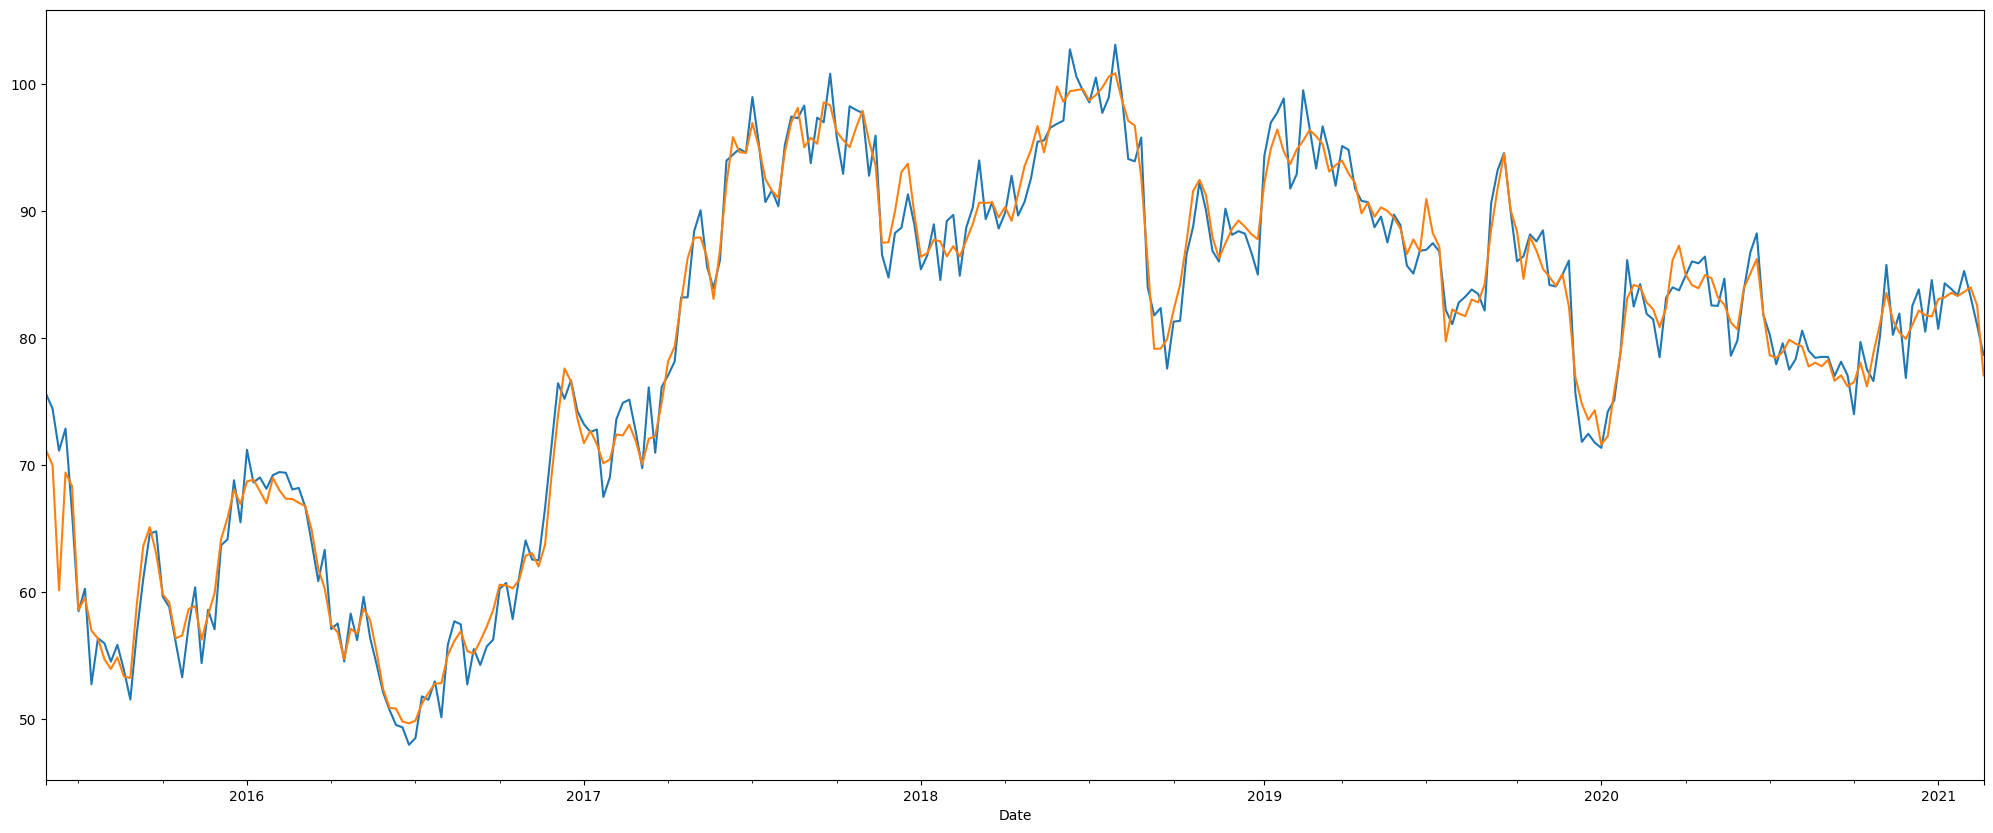

In [20]:
train['Close'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

### Feature Engineering for the test dataset essential for our SARIMAX model


# Feature Engineering for Test Dataset

### Lag Features
- `OpenL`: Lagged open price from the previous day.
- `OpenL2`: Lagged open price from 2 days ago.
- `OpenL3`: Lagged open price from 3 days ago.
- `OpenL4`: Lagged open price from 4 days ago.

### Volume Changes
- `Weekly_Volume_Change`: Weekly change in volume (1-day lag).
- `Monthly_Volume_Change`: Monthly change in volume (5-day lag).
- `Quarterly_Volume_Change`: Quarterly change in volume (20-day lag).

### Moving Averages
- `Volume_MA_5`: 5-day moving average of volume with forward fill.
- `Volume_MA_10`: 10-day moving average of volume with forward fill.
- `Volume_MA_20`: 20-day moving average of volume with forward fill.
- `Volume_MA_50`: 50-day moving average of volume with forward fill.

### Exponential Moving Averages (EMAs)
- `Volume_EMA_5`: 5-day exponential moving average of volume with forward fill.
- `Volume_EMA_10`: 10-day exponential moving average of volume with forward fill.
- `Volume_EMA_20`: 20-day exponential moving average of volume with forward fill.
- `Volume_EMA_50`: 50-day exponential moving average of volume with forward fill.

### Handling Missing Values
- Filled missing values with forward fill (`method='ffill'`) for moving averages and EMAs.
- Filled remaining missing values with backward fill (`method='bfill'`).

These engineered features provide a richer set of data for analysis and modeling.



In [21]:
#Pre forecast feature engineering
test['OpenL'] = test['Open'].shift(1)
test['OpenL'][0] = test['Open'][0]
test['OpenL2'] = test['Open'].shift(2)
test['OpenL2'][0:2] = test['Open'][0:2]
test['OpenL3'] = test['Open'].shift(3)
test['OpenL3'][0:3] = test['Open'][0:3]
test['OpenL4'] = test['Open'].shift(4)
test['OpenL4'][0:4] = test['Open'][0:4]

test['Weekly_Volume_Change'] = test['Volume'].diff(1)
test['Weekly_Volume_Change'][0] = 0  # Fill the first value with 0

# Create a monthly change in volume feature (spanning 5 weeks)
test['Monthly_Volume_Change'] = test['Volume'].diff(5)
test['Monthly_Volume_Change'][:5] = 0  # Fill the first 5 values with 0

# Create a quarterly change in volume feature (spanning 20 weeks)
test['Quarterly_Volume_Change'] = test['Volume'].diff(20)
test['Quarterly_Volume_Change'][:20] = 0  # Fill the first 20 values with 0

test['Volume_MA_10'] = test['Volume'].rolling(window=10).mean()
test['Volume_MA_20'] = test['Volume'].rolling(window=20).mean()
test['Volume_MA_50'] = test['Volume'].rolling(window=50).mean()
test['Volume_MA_5'] = test['Volume'].rolling(window=5).mean()

test['Volume_MA_10'].fillna(method='ffill', inplace=True)
test['Volume_MA_20'].fillna(method='ffill', inplace=True)
test['Volume_MA_50'].fillna(method='ffill', inplace=True)
test['Volume_MA_5'].fillna(method='ffill', inplace=True)

# Calculate Exponential Moving Averages (EMAs) for volume with different spans
test['Volume_EMA_10'] = test['Volume'].ewm(span=10, adjust=False).mean()
test['Volume_EMA_20'] = test['Volume'].ewm(span=20, adjust=False).mean()
test['Volume_EMA_50'] = test['Volume'].ewm(span=50, adjust=False).mean()
test['Volume_EMA_5'] = test['Volume'].ewm(span=5, adjust=False).mean()

test['Volume_EMA_10'].fillna(method='ffill', inplace=True)
test['Volume_EMA_20'].fillna(method='ffill', inplace=True)
test['Volume_EMA_50'].fillna(method='ffill', inplace=True)
test['Volume_EMA_5'].fillna(method='ffill', inplace=True)

test.fillna(method='bfill', inplace=True)


/tmp/ipykernel_20/3928116487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['OpenL'][0] = test['Open'][0]
/tmp/ipykernel_20/3928116487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['OpenL2'][0:2] = test['Open'][0:2]
/tmp/ipykernel_20/3928116487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['OpenL3'][0:3] = test['Open'][0:3]
/tmp/ipykernel_20/3928116487.py:9: SettingWithCopyWarning: 
A value is trying to 

### Predicting the close prices using the SARIMAX model

In [22]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['Open', 'OpenL','OpenL2', 'OpenL3','OpenL4','Volume','Weekly_Volume_Change','Monthly_Volume_Change']]))
test['Close'] = predict.values
test.head(5)

,id,Open,Volume,OpenL,OpenL2,OpenL3,OpenL4,Weekly_Volume_Change,Monthly_Volume_Change,Quarterly_Volume_Change,Volume_MA_10,Volume_MA_20,Volume_MA_50,Volume_MA_5,Volume_EMA_10,Volume_EMA_20,Volume_EMA_50,Volume_EMA_5,Close
Date,,,,,,,,,,,,,,,,,,,
2021-03-01,0,72.708331,205897600,72.708331,72.708331,72.708331,72.708331,0.0,0.0,0.0,204137180.0,188484830.0,189798138.0,197163160.0,2.058976e+08,2.058976e+08,2.058976e+08,2.058976e+08,77.032767
2021-03-08,1,73.310886,214095600,72.708331,73.310886,73.310886,73.310886,8198000.0,0.0,0.0,204137180.0,188484830.0,189798138.0,197163160.0,2.073881e+08,2.066784e+08,2.062191e+08,2.086303e+08,76.850555
2021-03-15,2,70.610119,151601700,73.310886,72.708331,70.610119,70.610119,-62493900.0,0.0,0.0,204137180.0,188484830.0,189798138.0,197163160.0,1.972452e+08,2.014330e+08,2.040772e+08,1.896207e+08,75.943236
2021-03-22,3,70.256017,193982500,70.610119,73.310886,72.708331,70.256017,42380800.0,0.0,0.0,204137180.0,188484830.0,189798138.0,197163160.0,1.966519e+08,2.007234e+08,2.036814e+08,1.910747e+08,76.371383
2021-03-29,4,68.258324,220238400,70.256017,70.610119,73.310886,72.708331,26255900.0,0.0,0.0,204137180.0,188484830.0,189798138.0,197163160.0,2.009404e+08,2.025820e+08,2.043307e+08,2.007959e+08,76.570922


### Creating date column as required by the hackathon

In [23]:
test['Date'] = test.index
test.dtypes

id                                  int64
Open                              float64
Volume                              int64
OpenL                             float64
OpenL2                            float64
OpenL3                            float64
OpenL4                            float64
Weekly_Volume_Change              float64
Monthly_Volume_Change             float64
Quarterly_Volume_Change           float64
Volume_MA_10                      float64
Volume_MA_20                      float64
Volume_MA_50                      float64
Volume_MA_5                       float64
Volume_EMA_10                     float64
Volume_EMA_20                     float64
Volume_EMA_50                     float64
Volume_EMA_5                      float64
Close                             float64
Date                       datetime64[ns]
dtype: object

### Plotting predicted values for the Close prices in the test dataset

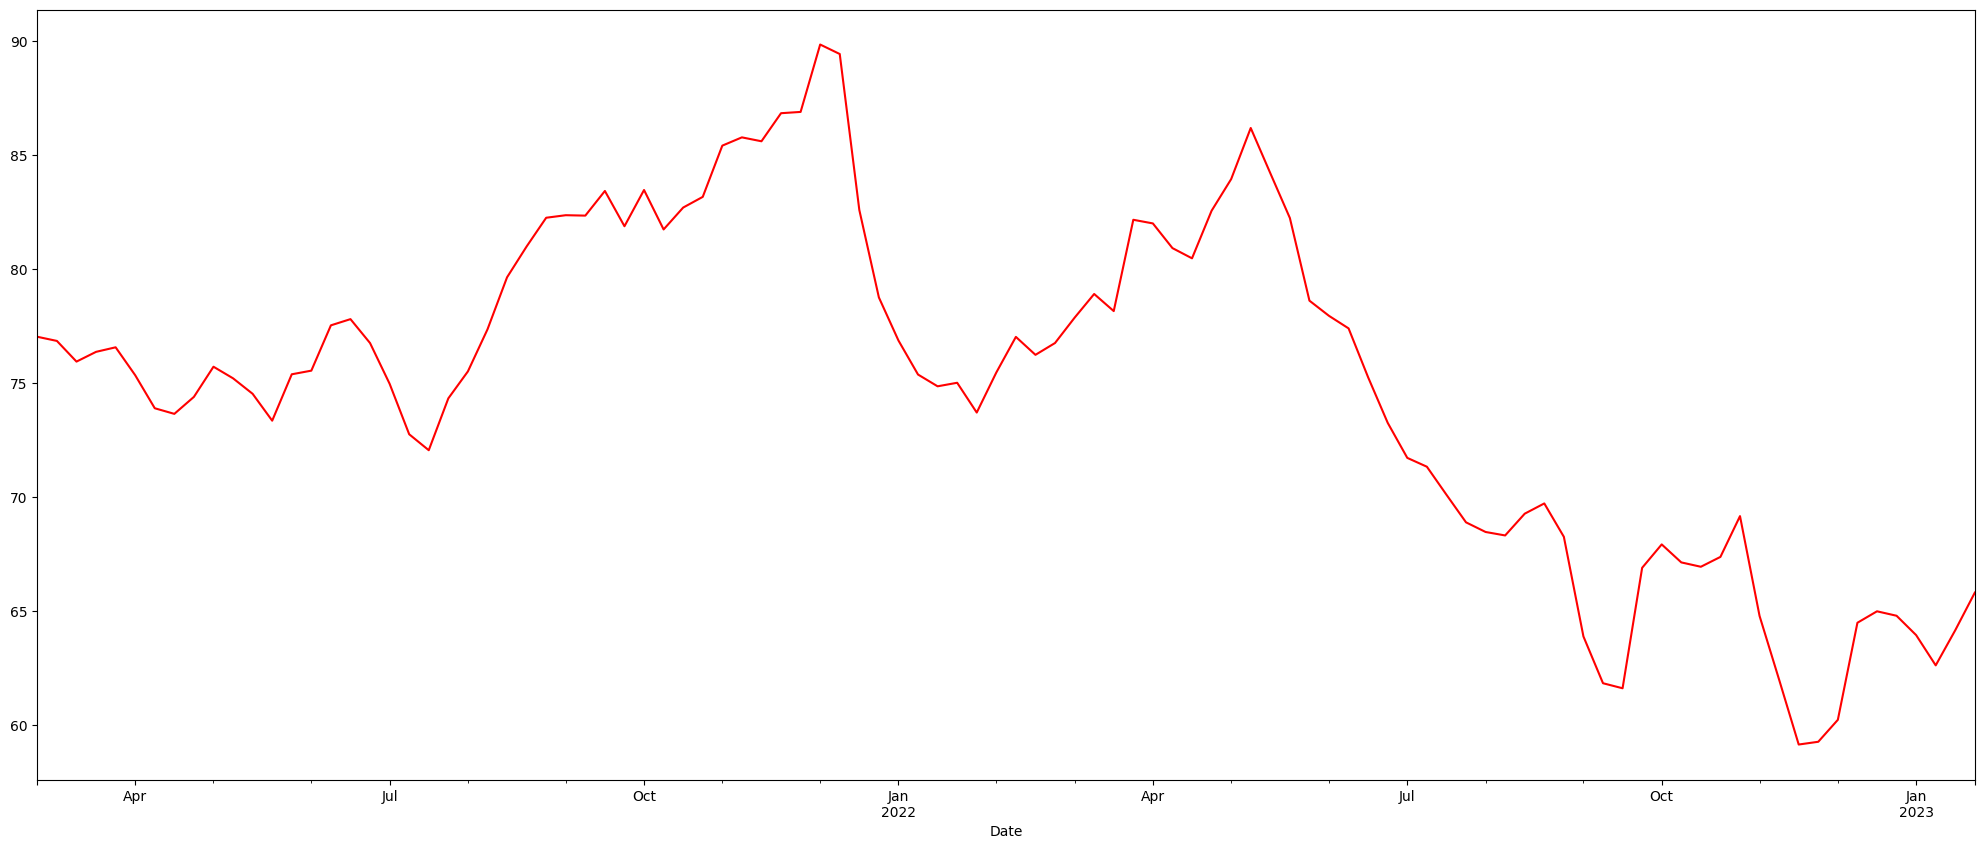

In [24]:
#Predicted Values
test['Close'].plot(color = 'red')
plt.show()

#### In this code, the dataset is split into training and testing sets, with the SARIMA model trained on the training data. The model is then used to make predictions on the testing data. Two evaluation metrics, Root Mean Squared Error (RMSE) and Symmetric Mean Absolute Percentage Error (SMAPE), are calculated to assess the model's performance. Additionally, two plots are generated to visualize the fit of the model on both the training and testing data. The first plot compares the observed and predicted values for the training data, and the second plot overlays the testing data and the corresponding predictions

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08484D+00    |proj g|=  7.17455D+10


 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17      1     21      1     0     0   7.175D+10   2.085D+00
  F =   2.0848385036013797     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Root Mean Squared Error (RMSE): 1.6063122663857694
Symmetric Mean Absolute Percentage Error (SMAPE): 1.6466115935596197


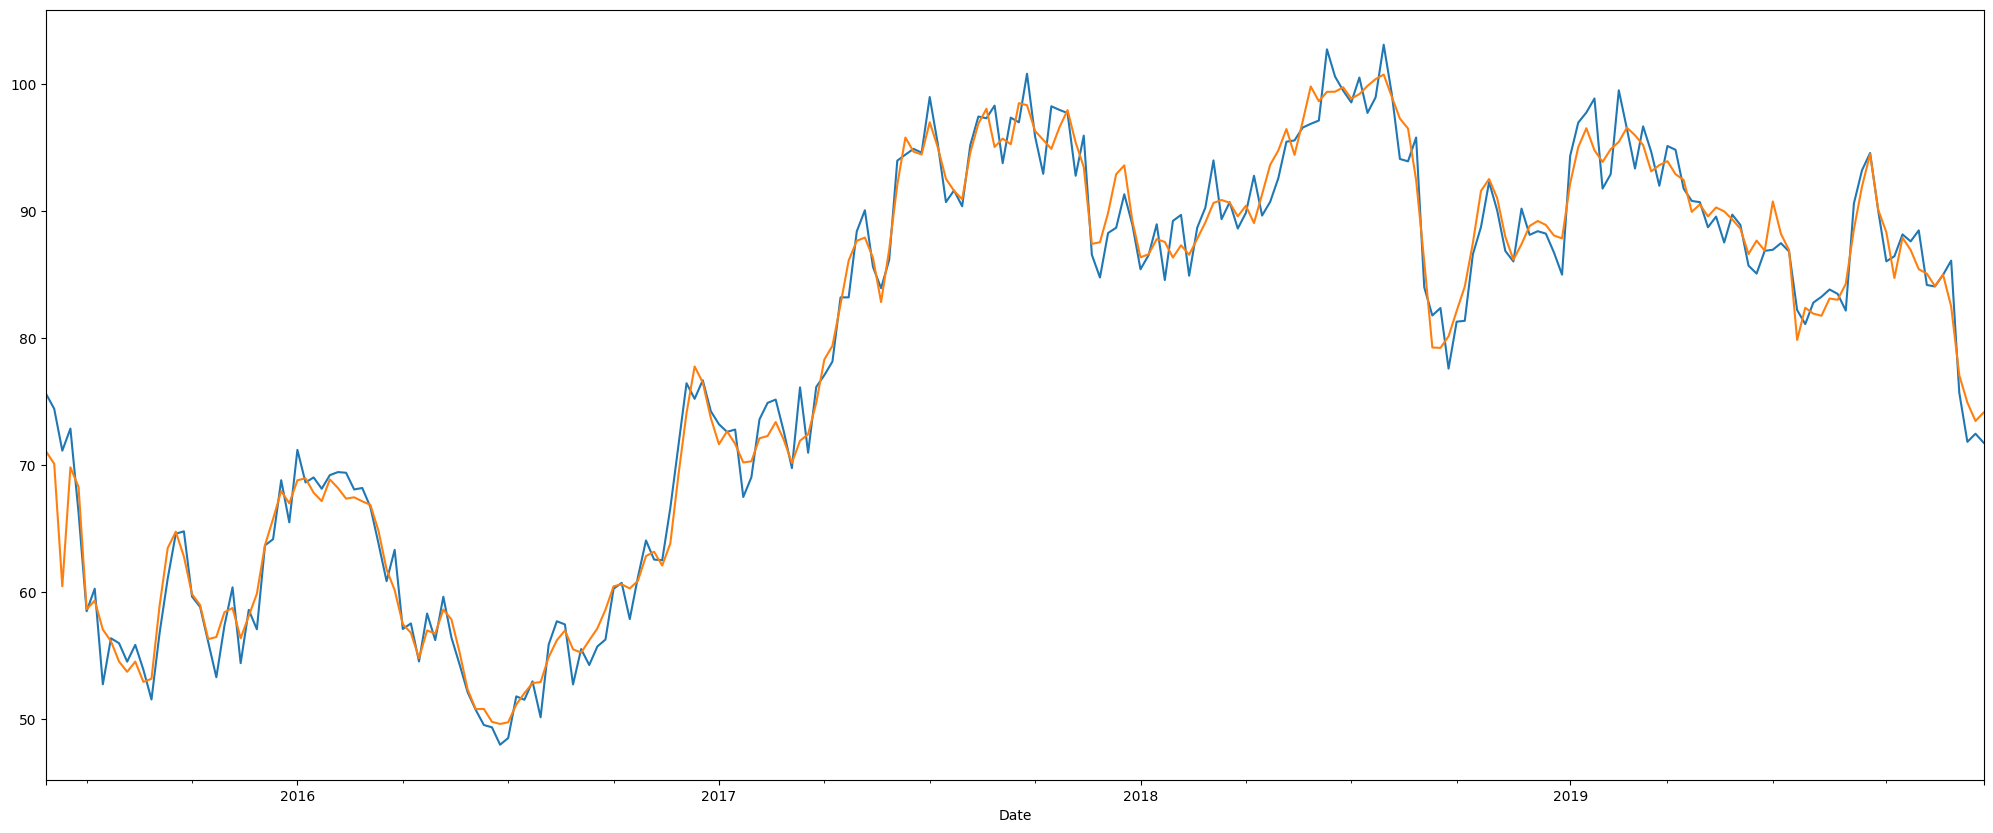

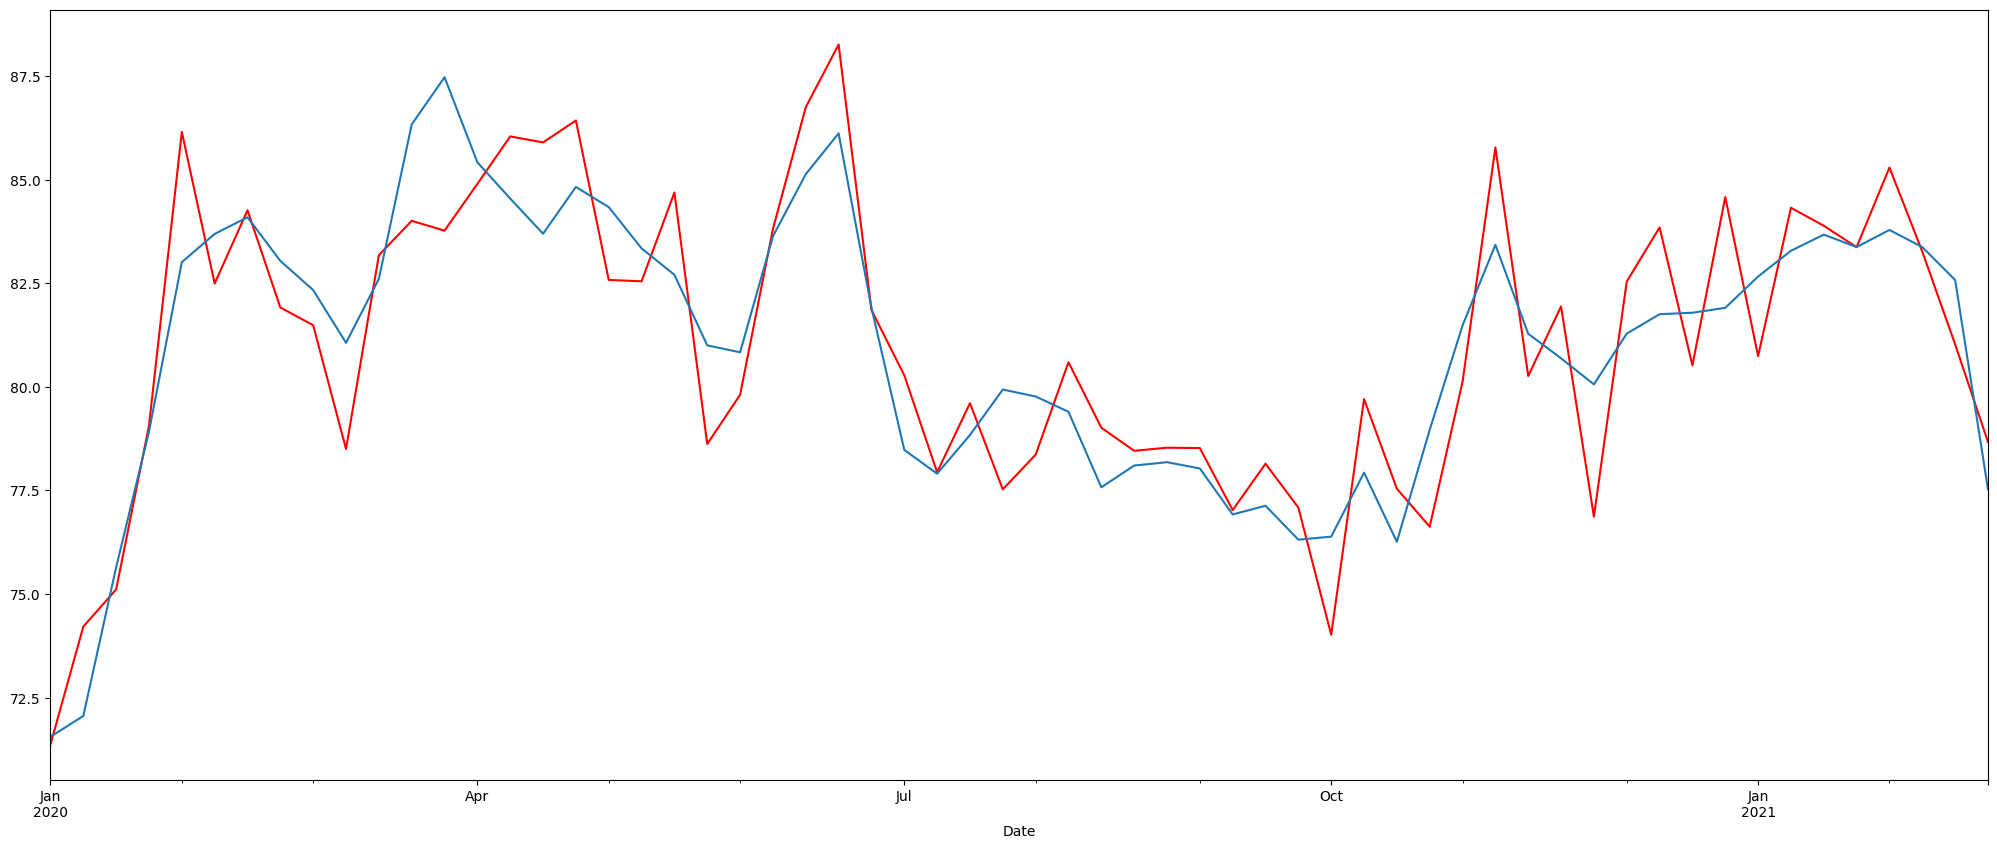

In [25]:
# Define the split point (e.g., 80% training, 20% testing)
split_percentage = 0.8
split_point = int(len(train) * split_percentage)

# Split the dataset
train_data = train.iloc[:split_point]
test_data = train.iloc[split_point:]

# Train the SARIMA model on the training data
endog = train_data['Close']
exog = sm.add_constant(train_data[['Open', 'OpenL','OpenL2', 'OpenL3','OpenL4','Volume','Weekly_Volume_Change','Monthly_Volume_Change']])
mod1 = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,0,1), seasonal_order=(5, 0, 0, 5))
model_fit1 = mod1.fit()

# Make predictions on the testing data
endog_test = test_data['Close']
exog_test = sm.add_constant(test_data[['Open', 'OpenL','OpenL2', 'OpenL3','OpenL4','Volume','Weekly_Volume_Change','Monthly_Volume_Change']])
predicted_values = model_fit1.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=exog_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(endog_test, predicted_values))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_value = smape(endog_test, predicted_values)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape_value)
train_data['Close'].plot(figsize=(25,10))
model_fit1.fittedvalues.plot()
plt.show()

endog_test.plot(figsize=(25,10),color = 'red')
predicted_values.plot()
plt.show()



### SMAPE and RMSE :
- Root Mean Squared Error (RMSE): 1.6063122663857694
- Symmetric Mean Absolute Percentage Error (SMAPE): 1.6466115935596197

## Predicting Strategy

### Performing feature engineering on test data to suggest the best strategy (buy, sell or hold) for clients 
### The features we have used have been chosen based on the correlation plot.
#### In this code, feature engineering is applied to the 'test' dataset, which includes generating lagged values for 'Close,' calculating Exponential Weighted Moving Averages (EWMA) for both 'Close' and 'Open' prices over different time windows, computing Simple Moving Averages (SMA) for 'Open' and 'Close,' and calculating the Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD) indicators. Additionally, missing values are handled using backward filling.


# Feature Engineering for Additional Features in Test Dataset

### Lag Features for Close Price
- `CloseL`: Lagged close price from the previous day.
- `CloseL2`: Lagged close price from 2 days ago.

### Exponential Weighted Moving Averages (EWMA)
- `EWMA_close`: Exponential Weighted Moving Average of the close price over a window of 5 weeks.
- `EWMA_close2`: Exponential Weighted Moving Average of the close price over a window of 10 weeks.
- `EWMA_open`: Exponential Weighted Moving Average of the open price over a window of 5 weeks.
- `EWMA_open2`: Exponential Weighted Moving Average of the open price over a window of 10 weeks.

### Simple Moving Averages (SMA)
- `SMA_open`: Simple Moving Average of open prices over a window of 5 weeks.
- `SMA_open2`: Simple Moving Average of open prices over a window of 10 weeks.
- `SMA_close`: Simple Moving Average of close prices over a window of 5 weeks.
- `SMA_close2`: Simple Moving Average of close prices over a window of 10 weeks.

### Relative Strength Index (RSI)
- `RSI`: The Relative Strength Index (RSI) calculated using a window of 14 days.

### Moving Average Convergence Divergence (MACD)
- `MACD`: The Moving Average Convergence Divergence (MACD) calculated with a short window of 12 and a long window of 26.
- `Signal_Line`: The signal line used in conjunction with the MACD calculation.

### Handling Missing Values
- Filled missing values with backward fill (`method='bfill'`).

These engineered features add valuable information for analyzing and modeling financial data, including momentum indicators like RSI and MACD, as well as various moving averages and lagged features for historical trends.


In [26]:

test['CloseL'] = test['Close'].shift(1)
test['CloseL'][0] = test['Close'][0]
test['CloseL2'] = test['Close'].shift(2)
test['CloseL2'][0:2] = test['Close'][0:2]

#Exponential Weighted Moving Average over a window of 5 weeks
test['EWMA_close'] = test['Close'].ewm(span=5, adjust=False).mean()
#Exponential Weighted Moving Average over a window of 10 weeks
test['EWMA_close2'] = test['Close'].ewm(span=10, adjust=False).mean()
#Exponential Weighted Moving Average over a window of 5 weeks for open prices
test['EWMA_open'] = test['Open'].ewm(span=5, adjust=False).mean()
#Exponential Weighted Moving Average over a window of 10 weeks for open prices
test['EWMA_open2'] = test['Open'].ewm(span=10, adjust=False).mean()
#SMA over a window of 5 weeks on Open
test['SMA_open'] = test['Open'].rolling(window=5).mean()
#SMA over a window of 10 weeks on Open
test['SMA_open2'] = test['Open'].rolling(window=10).mean()
#SMA over a window of 5 weeks on Close
test['SMA_close'] = test['Close'].rolling(window=5).mean()
#SMA over a window of 10 weeks on Close
test['SMA_close2'] = test['Close'].rolling(window=10).mean()
test['RSI'] = calculate_rsi(test['Close'], window=14)
test['MACD'], test['Signal_Line'] = calculate_macd(test['Close'], short_window=12, long_window=26)

test.fillna(method='bfill', inplace=True)

/tmp/ipykernel_20/1043645186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['CloseL'][0] = test['Close'][0]
/tmp/ipykernel_20/1043645186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['CloseL2'][0:2] = test['Close'][0:2]


# XGBOOST

### In this code, an XGBoost classifier is trained on the preprocessed training data with 20 selected features. It achieves improved accuracy compared to K-Nearest Neighbors (KNN), Naive Bayes Gaussian, LightGBM, and ensemble models due to the following reasons:

- Feature Selection: Feature selection based on ANOVA F-statistic is employed to choose the most relevant features for classification. This ensures that only the most informative features are used, improving model performance.

- XGBoost: XGBoost is a powerful ensemble machine learning algorithm known for its efficiency and accuracy. It can capture complex relationships in the data, making it well-suited for this task.

- Tuned Hyperparameters: Hyperparameters of the XGBoost model, such as the number of estimators, max depth, learning rate, and regularization parameters (e.g., reg_lambda, reg_alpha), are fine-tuned to enhance predictive performance.

- Scalability: XGBoost is capable of handling large datasets and can efficiently process a substantial number of features, making it suitable for this financial prediction task.

- Consistent Results: The XGBoost model provides consistent results and can generalize well to unseen data, ensuring robustness in real-world applications.

- These aspects collectively contribute to the superior accuracy of the XGBoost model compared to other traditional and ensemble models.

#### First we split the training data into training and validation sets.

In [27]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create an instance of LabelEncoder
label_encoder = LabelEncoder()



# Scale the features
scaler = StandardScaler()
X_train1 = train[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
X_train1 = scaler.fit_transform(X_train1)
y_train = train['Strategy']
y_train_encoded = label_encoder.fit_transform(train['Strategy'])

# Feature selection based on ANOVA F-statistic
selector = SelectKBest(f_classif, k=20)  # Select top 5 features
X_train_new = selector.fit_transform(X_train1, y_train)

# Split the training data into training and validation sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_train_new, y_train_encoded, test_size=0.2, random_state=0)

# Create and train the XGBoost classifier on the training data
xgb = XGBClassifier(n_estimators=440, max_depth=3, learning_rate=0.005, random_state=0,subsample = 1,reg_lambda = 2,reg_alpha = 0.1)
xgb.fit(X_train, y_train)

# Make predictions on the test data
predictions_encoded1 = xgb.predict(X_test)

# Reverse the label encoding to get back the original string labels
predictions1 = label_encoder.inverse_transform(predictions_encoded1)

# Calculate the accuracy of the model
accuracy = accuracy_score(label_encoder.inverse_transform(y_test), predictions1)
print("Accuracy:", accuracy)

# Make predictions on the training data
train_predictions_encoded = xgb.predict(X_train)

# Reverse the label encoding to get back the original string labels for training data
train_predictions = label_encoder.inverse_transform(train_predictions_encoded)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, train_predictions_encoded)
print("Training Accuracy:", train_accuracy)

# Scale the test data
X_test = test[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
X_test = scaler.transform(X_test)

# Apply feature selection to the test data using the same selector
X_test_new = selector.transform(X_test)

predictions_encoded = xgb.predict(X_test_new)

# Reverse the label encoding to get back the original string labels
predictions = label_encoder.inverse_transform(predictions_encoded)

# Assign the 'Strategy' predictions to the test DataFrame
test['Strategy'] = predictions

Accuracy: 0.8833333333333333
Training Accuracy: 0.8875


### We successfully prevented overfitting in our XGBoost model by carefully tuning hyperparameters. Through this process, we achieved a balanced training and validation accuracy of approximately 88%. The chosen hyperparameters for our well-generalizing model include:

- n_estimators=440
- max_depth=3
- learning_rate=0.005
- random_state=0
- subsample=1
- reg_lambda=2
- reg_alpha=0.1

### Now, we train the model using the whole training data 

In [28]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()


# Handle missing values
train.fillna(method='bfill', inplace=True)

# Scale the features
scaler = StandardScaler()
X_train = train[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
X_train = scaler.fit_transform(X_train)
y_train = train['Strategy']
y_train_encoded = label_encoder.fit_transform(train['Strategy'])

# Feature selection based on ANOVA F-statistic
selector = SelectKBest(f_classif, k=20)  # Select top 5 features
X_train_new = selector.fit_transform(X_train, y_train)

# Create and train the XGBoost classifier on the training data
xgb = XGBClassifier(n_estimators=440, max_depth=3, learning_rate=0.005, random_state=0,subsample = 1,reg_lambda = 2,reg_alpha = 0.1)
xgb.fit(X_train_new, y_train_encoded)

# Scale the test data
X_test = test[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
X_test = scaler.transform(X_test)

# Apply feature selection to the test data using the same selector
X_test_new = selector.transform(X_test)

predictions_encoded = xgb.predict(X_test_new)

# Reverse the label encoding to get back the original string labels
predictions = label_encoder.inverse_transform(predictions_encoded)

# Assign the 'Strategy' predictions to the test DataFrame
test['Strategy'] = predictions

#Make predictions on the training data
train_predictions_encoded = xgb.predict(X_train_new)

# Reverse the label encoding to get back the original string labels for training data
train_predictions = label_encoder.inverse_transform(train_predictions_encoded)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.8433333333333334


In [29]:
predictions

array(['Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Hold', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell',
       'Sell', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Sell', 'Sell',
       'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Hold',
       'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy',
       'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Buy', 'Buy', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Buy', 'Hold', 'Hold'],
      dtype=object)

In [30]:
predictions.shape

(100,)

### We tested other models like KNN and Ensemble to compare the accuracies

# K Nearest Neighbours

In [31]:
# # Create an instance of LabelEncoder
# label_encoder = LabelEncoder()

# # Scale the features
# scaler = StandardScaler()
# X_train = train[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
# X_train = scaler.fit_transform(X_train)
# y_train = train['Strategy']
# y_train_encoded = label_encoder.fit_transform(train['Strategy'])

# # Feature selection based on ANOVA F-statistic
# selector = SelectKBest(f_classif, k=20)  # Select top 20 features
# X_train_new = selector.fit_transform(X_train, y_train)

# # Create a K-Nearest Neighbors (KNN) classifier
# knn = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors

# # Train the KNN classifier on the training data
# knn.fit(X_train_new, y_train_encoded)

# # Scale the test data
# X_test = test[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
# X_test = scaler.transform(X_test)

# # Apply feature selection to the test data using the same selector
# X_test_new = selector.transform(X_test)

# # Make predictions using the KNN classifier
# predictions_encoded = knn.predict(X_test_new)

# # Reverse the label encoding to get back the original string labels
# predictions = label_encoder.inverse_transform(predictions_encoded)

# # Assign the 'Strategy' predictions to the test DataFrame
# test['Strategy'] = predictions
# train_predictions = knn.predict(X_train_new)

# # # Calculate the training accuracy
# train_accuracy = accuracy_score(y_train, train_predictions)
# print("Training Accuracy:", train_accuracy)

# Ensemble

In [32]:
# import pandas as pd
# from xgboost import XGBClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.preprocessing import LabelEncoder
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import VotingClassifier
# from lightgbm import LGBMClassifier
# from sklearn.metrics import accuracy_score


# # Create an instance of LabelEncoder
# label_encoder = LabelEncoder()

# # Scale the features
# scaler = StandardScaler()
# X_train = train[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
# X_train = scaler.fit_transform(X_train)
# y_train = train['Strategy']
# y_train_encoded = label_encoder.fit_transform(train['Strategy'])


# # Feature selection based on ANOVA F-statistic
# selector = SelectKBest(f_classif, k=15)  # Select top 5 features
# X_train_new = selector.fit_transform(X_train, y_train)

# # Create and train multiple XGBoost classifiers with different hyperparameters
# xgb_classifier_1 = XGBClassifier(n_estimators=460, max_depth=3, learning_rate=0.00495, random_state=0,subsample = 1,reg_lambda = 2,reg_alpha = 0.1)
# xgb_classifier_2 = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)
# xgb_classifier_3 = XGBClassifier(n_estimators=50, max_depth=2, learning_rate=0.2, random_state=123)

# lgbm_params_1 = {
#     'n_estimators': 150,
#     'max_depth': 3,
#     'learning_rate': 0.01,
#     'random_state': 0
# }

# lgbm_classifier_1 = LGBMClassifier(**lgbm_params_1)


# # Create a K-Nearest Neighbors classifier
# knn_classifier = KNeighborsClassifier(n_neighbors=3)

# # Create a VotingClassifier that ensembles XGBoost and KNN
# ensemble_classifier = VotingClassifier(estimators=[
#     ('xgb1', xgb_classifier_1),
#     ('xgb2', xgb_classifier_2),
#     ('xgb3', xgb_classifier_3),
# ], voting='soft')   # 'soft' for probability-based voting

# # Fit the ensemble classifier on the training data
# ensemble_classifier.fit(X_train_new, y_train_encoded)


# # Scale the test data
# X_test = test[['Open','OpenL','OpenL2','OpenL3', 'Close','CloseL','CloseL2', 'Volume','SMA_open','SMA_open2','SMA_close','SMA_close2','EWMA_open','EWMA_open2','EWMA_close','EWMA_close2', 'RSI', 'MACD','Signal_Line','Weekly_Volume_Change','Monthly_Volume_Change','Quarterly_Volume_Change','Volume_MA_5','Volume_MA_10','Volume_MA_20','Volume_MA_50','Volume_EMA_5','Volume_EMA_10','Volume_EMA_20','Volume_EMA_50']]
# X_test = scaler.transform(X_test)

# # Apply feature selection to the test data using the same selector
# X_test_new = selector.transform(X_test)


# predictions_encoded = ensemble_classifier.predict(X_test_new)

# # Reverse the label encoding to get back the original string labels
# predictions = label_encoder.inverse_transform(predictions_encoded)

# # Assign the 'Strategy' predictions to the test DataFrame
# test['Strategy'] = predictions

# # Make predictions on the training data
# train_predictions_encoded = ensemble_classifier.predict(X_train_new)

# # Reverse the label encoding to get back the original string labels for training data
# train_predictions = label_encoder.inverse_transform(train_predictions_encoded)

# # Calculate the training accuracy
# train_accuracy = accuracy_score(y_train, train_predictions)
# print("Training Accuracy:", train_accuracy)

### Creating submission dataframe and adding the required columns to the same

In [33]:
submission = pd.DataFrame()
submission["Date"] = test["Date"]
submission["Close"] = test["Close"]
submission["Strategy"] = test["Strategy"]
submission.index = test['id']


In [34]:
test.head()

,id,Open,Volume,OpenL,OpenL2,OpenL3,OpenL4,Weekly_Volume_Change,Monthly_Volume_Change,Quarterly_Volume_Change,...,EWMA_open,EWMA_open2,SMA_open,SMA_open2,SMA_close,SMA_close2,RSI,MACD,Signal_Line,Strategy
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,0,72.708331,205897600,72.708331,72.708331,72.708331,72.708331,0.0,0.0,0.0,...,72.708331,72.708331,71.028735,70.678602,76.553773,75.577195,0.000000,0.000000,0.000000,Buy
2021-03-08,1,73.310886,214095600,72.708331,73.310886,73.310886,73.310886,8198000.0,0.0,0.0,...,72.909183,72.817887,71.028735,70.678602,76.553773,75.577195,0.000000,-0.014535,-0.002907,Buy
2021-03-15,2,70.610119,151601700,73.310886,72.708331,70.610119,70.610119,-62493900.0,0.0,0.0,...,72.142828,72.416474,71.028735,70.678602,76.553773,75.577195,0.000000,-0.098137,-0.021953,Buy
2021-03-22,3,70.256017,193982500,70.610119,73.310886,72.708331,70.256017,42380800.0,0.0,0.0,...,71.513891,72.023664,71.028735,70.678602,76.553773,75.577195,28.210631,-0.128364,-0.043235,Buy
2021-03-29,4,68.258324,220238400,70.256017,70.610119,73.310886,72.708331,26255900.0,0.0,0.0,...,70.428702,71.339057,71.028735,70.678602,76.553773,75.577195,36.552514,-0.134665,-0.061521,Buy


### Convert the dataframe to a csv file

In [35]:
submission.to_csv('submission.csv', index=True)